### InterRater Evaluation Pipeline

In [1]:
print("strawberry")

# loss function and metrics
from trustworthai.utils.losses_and_metrics.dice_loss import DiceLossWithWeightedEmptySlices
from trustworthai.utils.losses_and_metrics.dice_loss_metric import DiceLossMetric, SsnDiceMeanMetricWrapper

# predefined training dataset
from trustworthai.utils.data_preprep.dataset_pipelines import load_data
from torch.utils.data import ConcatDataset

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.fitters.p_unet_fitter import PUNetLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# model
from trustworthai.journal_run.model_load.load_ssn import load_ssn
from trustworthai.journal_run.model_load.load_punet import load_p_unet
from trustworthai.journal_run.model_load.load_deterministic import load_deterministic
from trustworthai.journal_run.model_load.load_evidential import load_evidential
from trustworthai.models.stochastic_wrappers.ssn.LowRankMVCustom import LowRankMultivariateNormalCustom
from trustworthai.models.stochastic_wrappers.ssn.ReshapedDistribution import ReshapedDistribution

# optimizer and lr scheduler
import torch


import numpy as np
from tqdm import tqdm
import scipy.stats
from trustworthai.utils.plotting.saving_plots import save, imsave
from trustworthai.utils.print_and_write_func import print_and_write

# misc
import argparse
import os
import shutil
import shlex
from collections import defaultdict
from tqdm import tqdm
import sys
from natsort import natsorted

import pandas as pd
from trustworthai.analysis.connected_components.connected_comps_2d import conn_comp_2d_analysis
from trustworthai.analysis.evaluation_metrics.challenge_metrics import getAVD, getDSC, getHausdorff, getLesionDetection, do_challenge_metrics
from sklearn import metrics
import math

import torch
import matplotlib.pyplot as plt
from trustworthai.utils.plotting.saving_plots import save
from trustworthai.utils.print_and_write_func import print_and_write
from trustworthai.analysis.calibration.helper_funcs import *
from tqdm import tqdm
from trustworthai.utils.logits_to_preds import normalize_samples

# data
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever
from trustworthai.utils.uncertainty_maps.entropy_map import entropy_map_from_samples


# evaluation code
from trustworthai.journal_run.evaluation.new_scripts.eval_helper_functions import *
from trustworthai.journal_run.evaluation.new_scripts.model_predictions import *
from trustworthai.analysis.connected_components.connected_comps_2d import *
print("banana")


strawberry
banana


In [2]:
import matplotlib.pyplot as plt
from trustworthai.utils.uncertainty_maps.entropy_map import entropy_map_from_samples

In [3]:
%load_ext autoreload

In [4]:
import seaborn as sns

In [5]:
from twaidata.torchdatasets.DirectoryParser3DMRIDataset import *

In [6]:
VOXELS_TO_WMH_RATIO = 382
VOXELS_TO_WMH_RATIO_EXCLUDING_EMPTY_SLICES = 140

In [22]:
class ARGS():
    def __init__(self):
    
        # folder arguments
        self.ckpt_dir = '/home/s2208943/ipdis/results/journal_models/'
        self.model_name = "ssn_prehead16_rank15_sdice0"
        self.model_ckpts_folder = "/home/s2208943/ipdis/results/journal_models/" # "/home/s2208943/ipdis/results/cross_validated_models/"
        self.repo_dir = "/home/s2208943/ipdis/WMH_UQ_assessment"
        self.result_dir = "trustworthai/journal_run/interrater_experiments/"
        self.model_type = "ssn"
        self.uncertainty_type = "ssn"
        
        # data generation arguments
        self.dataset = 'chal'
        self.seed = 3407
        self.test_split = 0.15
        self.val_split = 0.15
        self.empty_slice_retention = 0.1
        
        # general arguments for the loss function
        self.loss_name = 'dice+xent'#'dicev2'#'dice+xent'
        self.dice_factor = 1#5
        self.xent_factor = 1#0.01
        self.xent_weight = 'none'
        self.xent_reweighting=1
        self.dice_empty_slice_weight = 0.5
        self.tversky_beta = 0.7
        self.reduction = 'mean'#'mean_sum'
        
        # evidential arguments
        self.kl_factor=0.1
        self.kl_anneal_count=452*4
        self.use_mle=0
        self.analytic_kl=0

        # p-unet arguments
        self.kl_beta=10.
        self.use_prior_for_dice="false"
        self.punet_sample_dice_coeff=0.05
        self.latent_dim=12

        # ssn arguments
        self.ssn_rank=15
        self.ssn_epsilon=1e-5
        self.ssn_mc_samples=10
        self.ssn_sample_dice_coeff=0.05
        self.ssn_pre_head_layers=16
        
        # training paradigm arguments
        self.lr = 2e-4
        self.dropout_p = 0.1
        self.encoder_dropout1 = 0
        self.encoder_dropout2 = 0
        self.decoder_dropout1 = 0
        self.decoder_dropout2 = 0
        self.max_epochs = 100
        self.early_stop_patience = 15
        self.batch_size = 8#32
        self.cross_validate = "true"
        self.cv_split = 0
        self.cv_test_fold_smooth = 1
        self.weight_decay = 0.0001
        self.overwrite = "true"
        self.no_test_fold = 'false'

In [23]:
args = ARGS()

# sanitise arguments
args.overwrite = True if args.overwrite.lower() == "true" else False
args.cross_validate = True if args.cross_validate.lower() == "true" else False
args.use_prior_for_dice = True if args.use_prior_for_dice.lower() == "true" else False
print(f"CHECKPOINT DIR: {args.ckpt_dir}")
#print(args)


# check if folder exists
model_result_folder = os.path.join(args.repo_dir, args.result_dir)
if not args.overwrite:
    existing_files = os.listdir(model_result_folder)
    for f in existing_files:
        if args.model_name + "_" in f:
            raise ValueError(f"ovewrite = false and model results exist! folder={model_result_folder}, model_name={args.model_name}")
with open(os.path.join(model_result_folder, f"{args.model_name}_init.txt"), "w") as f:
                      f.write("generating results\n")
        
# setup xent reweighting factor
XENT_VOXEL_RESCALE = VOXELS_TO_WMH_RATIO - (1-args.empty_slice_retention) * (VOXELS_TO_WMH_RATIO - VOXELS_TO_WMH_RATIO_EXCLUDING_EMPTY_SLICES)

XENT_WEIGHTING = XENT_VOXEL_RESCALE/2
args.xent_reweighting = XENT_WEIGHTING

CHECKPOINT DIR: /home/s2208943/ipdis/results/journal_models/


In [24]:
%autoreload

In [25]:
MODEL_LOADERS = {
    "deterministic":load_deterministic,
    "mc_drop":load_deterministic,
    "evidential":load_evidential,
    "ssn":load_ssn,
    "punet":load_p_unet,
}

MODEL_OUTPUT_GENERATORS = {
    "deterministic":mc_drop_mean_and_samples,
    "mc_drop":mc_drop_mean_and_samples,
    "evidential":evid_mean,
    "ssn":ssn_mean_and_samples,
    "punet":punet_mean_and_samples,
    "ind":ssn_mean_and_samples,
    "ens":ensemble_mean_and_samples,
    "ssn_ens":ssn_ensemble_mean_and_samples,
}

### setting up model and data

In [9]:
# get the 3d dataloader
mss3_ds = MSS3InterRaterDataset()


In [10]:
len(mss3_ds)

68

In [11]:
xs, ys, ind = mss3_ds[10]

In [12]:
ind

'MSS3_ED_003_V1'

In [13]:
xs.keys(), ys.keys()

(dict_keys(['mask', 'FLAIR', 'T1']), dict_keys(['lacune', 'wmhes', 'wmhmvh']))

In [14]:
xs['mask'].shape

torch.Size([53, 240, 240])

In [15]:
import matplotlib.pyplot as plt

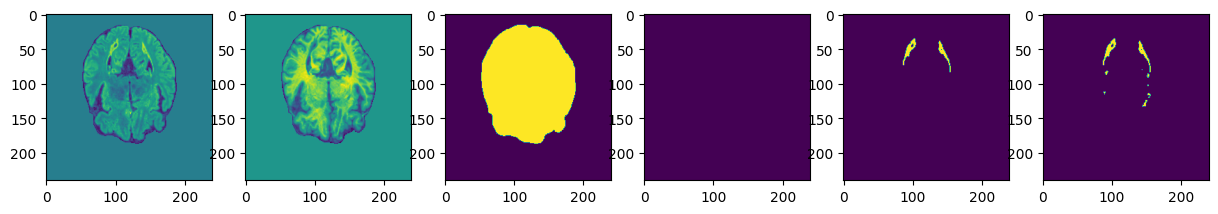

In [17]:
plt.figure(figsize=(15, 8))
plt.subplot(1,6,1)
plt.imshow(xs['FLAIR'][23])
plt.subplot(1,6,2)
plt.imshow(xs['T1'][23])
plt.subplot(1,6,3)
plt.imshow(xs['mask'][23])
plt.subplot(1,6,4)
plt.imshow(ys['lacune'][23])
plt.subplot(1,6,5)
plt.imshow(ys['wmhes'][23])
plt.subplot(1,6,6)
plt.imshow(ys['wmhmvh'][23])

In [22]:
# get data as lists
xs3d_test, ys3d_test = get_xs_and_ys(eval_ds)
gt_vols = GT_volumes(ys3d_test)

In [15]:
uncertainty_thresholds = torch.arange(0, 0.7, 0.01)

In [16]:
# load the model
model_dir = os.path.join(args.ckpt_dir, args.model_name)  
print("model dir: ", model_dir)
model_raw, loss, val_loss = MODEL_LOADERS[args.model_type](args)
model = load_best_checkpoint(model_raw, loss, model_dir, punet=args.model_type == "punet")

model dir:  /media/benp/NVMEspare/model_data/journal_models/ssn_tune/ssn_prehead16_rank15_sdice0


/home/benp/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.1.2, which is newer than your current Lightning version: v2.0.2
  rank_zero_warn(


### collecting basic results

In [17]:
# get data as lists
xs3d_test, ys3d_test = get_xs_and_ys(eval_ds)
gt_vols = GT_volumes(ys3d_test)

# load the predictions
means, samples, misc = get_means_and_samples(model_raw, eval_ds, num_samples=10, model_func=MODEL_OUTPUT_GENERATORS[args.uncertainty_type], args)

# run the evaluation on the means
chal_results = per_model_chal_stats(means, ys3d_test)

rmses = []
for m, y in zip(means, ys3d_test):
    rmses.append(fast_rmse(m.cuda().softmax(dim=1), y.cuda()).cpu())
rmses = torch.Tensor(rmses)
chal_results['rmse'] = rmses

chal_results['gt_vols'] = gt_vols

# run the evaluation on the samples
if samples[0] is not None:
    samples = [reorder_samples(s) for s in samples]
    sample_top_dices, sample_dices = per_sample_metric(samples, ys3d_test, f=fast_dice, do_argmax=True, do_softmax=False, minimise=False)
    sample_best_avds, sample_avds = per_sample_metric(samples, ys3d_test, f=fast_avd, do_argmax=True, do_softmax=False, minimise=True)
    sample_best_rmses, sample_rmses = per_sample_metric(samples, ys3d_test, f=fast_rmse, do_argmax=False, do_softmax=True, minimise=True)

    chal_results['best_dice'] = sample_top_dices
    chal_results['best_avd'] = sample_best_avds
    chal_results['best_rmse'] = sample_best_rmses

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.61it/s]


### collecting the full set of results

#### calculating the uncertainty maps

In [18]:
def entropy_map_from_samples(samples, do_normalize=True, **kwargs):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    if samples.shape[2] == 1:
        return entropy_map_from_samples_implicit(samples, do_normalize)
    else:
        assert samples.shape[2] == 2
    
    if do_normalize:
        probs = torch.nn.functional.softmax(samples, dim=2)
    else:
        probs = samples

    pic = torch.mean(probs, dim=0)
    ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1)

    return ent_map


def entropy_map_from_samples_implicit(samples, do_normalize, **kwargs):
    if do_normalize:
        probs = torch.sigmoid(samples)
    else:
        probs = samples
        
    pic = torch.mean(probs, dim=0)
    ent_map = (
        (-pic * torch.log(pic + 1e-30)) 
        + (-(1-pic) * torch.log((1-pic) + 1e-30))
    )
    return ent_map.squeeze()


def entropy_map_from_mean(mean, do_normalize=True, **kwargs):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    if mean.shape[1] == 1:
        raise ValueError("not implemented for implicit background class")
    else:
        assert mean.shape[1] == 2
    
    if do_normalize:
        probs = torch.nn.functional.softmax(mean, dim=1)
    else:
        probs = mean
    ent_map = torch.sum(-probs * torch.log(probs+1e-30), dim=1)

    return ent_map


UNCERTAINTY_MAP_GENERATORS = {
    "deterministic":entropy_map_from_mean,
    "mc_drop":entropy_map_from_samples,
    "evidential_mean":entropy_map_from_mean,
    "evidential_aleatoric":None,
    "ssn":entropy_map_from_samples,
    "punet":entropy_map_from_samples,
    "ssn_ens":entropy_map_from_samples,
    "ens":entropy_map_from_samples,
    "softmax_ent":entropy_map_from_mean,
    "ind":entropy_map_from_samples,
}


def get_uncertainty_maps(means, samples, misc):
    ent_maps = []
    umap_func = UNCERTAINTY_MAP_GENERATORS[args.uncertainty_type]
    print("generating uncertainty maps")
    for idx in tqdm(range(len(means)), position=0, leave=True):
        umap_params = {"mean":means[idx], "samples":samples[idx], "misc":misc[idx], "do_normalize":True}
        ent_maps.append(umap_func(**umap_params))
    return ent_maps

In [19]:
ent_maps = get_uncertainty_maps(means, samples, misc)

generating uncertainty maps


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 13.83it/s]


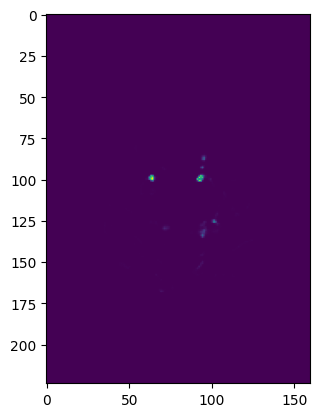

In [20]:
ent_maps[0].shape
plt.imshow(ent_maps[0][40])

#### best vd
I would like to say whether we can make say a deterministic policy, so we could go with what is the skew of the data for example. Nice.

In [21]:
vds = []
for m, y in zip(means, ys3d_test):
    vds.append(fast_vd(m.cuda().argmax(dim=1), y.cuda()))

In [22]:
%autoreload

In [23]:
_, sample_vds = per_sample_metric(samples, ys3d_test, f=fast_vd, do_argmax=True, do_softmax=False, minimise=True, take_abs=False)
sample_vd_skew = scipy.stats.skew(sample_vds, axis=1, bias=True)

chal_results['sample_vd_skew'] = sample_vd_skew
for s in range(sample_vds.shape[1]):
    chal_results[f'sample_{s}_vd'] = sample_vds[:,s]



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.61it/s]


In [24]:
scipy.stats.skew(sample_vds, axis=1)

array([1.2447232 , 0.8808395 , 0.58777446, 0.58741945, 0.27889758,
       1.2617388 , 0.52344364, 0.16407624, 1.2901471 , 0.4213741 ,
       1.8549193 , 1.2554984 , 0.2531027 , 0.12305465, 0.28275523,
       0.9047476 , 0.21827538, 0.40160665, 0.21219267, 0.8510561 ,
       0.97141117, 0.9015454 , 0.7161618 , 0.6542103 , 0.69706917,
       0.6481604 , 0.64480346, 1.5291561 , 1.8575958 , 1.5443923 ,
       0.7584514 , 0.4083327 , 1.8326076 , 1.1904036 , 0.74639094,
       0.9281229 , 1.5705235 , 1.0845525 , 1.3185822 ], dtype=float32)

### GeD

In [25]:
def fast_iou(pred, target):
    p1 = (pred == 1)
    t1 = (target == 1)
    intersection = (pred == 1) & (target == 1)
    numerator = intersection.sum()
    denominator = p1.sum() + t1.sum() - numerator
    return (numerator/(denominator + 1e-30)).item()

In [26]:
def iou_GED(means, ys3d_test, samples):
    geds = []
    
    for i in tqdm(range(len(means)), position=0, leave=True):
        y = ys3d_test[i].cuda()
        ss = samples[i].cuda().argmax(dim=2)
        num_samples = ss.shape[0]
        
        dists_ab = 0
        
        # print(y.sum())
        
        for s in ss:
            pred = s#.argmax(dim=1)
            dists_ab += (1 - fast_iou(pred, y))
            # print(dists_ab)
            # print(s.shape)
        
        dists_ab /= num_samples
        dists_ab *= 2
        
        dists_ss = 0
        for j, s1 in enumerate(ss):
            for k, s2 in enumerate(ss):
                if j == k:
                    continue
                dists_ss += (1 - fast_iou(s1, s2))
        
        dists_ss /= (num_samples * (num_samples - 1))
        
        ged = dists_ab - dists_ss
        if not np.isnan(ged):
            geds.append(ged)
        #break
        
    return torch.Tensor(geds)

In [27]:
samples[0].shape

torch.Size([10, 48, 2, 224, 160])

In [28]:
geds = iou_GED(means, ys3d_test, samples)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00,  9.85it/s]


In [29]:
chal_results['GED^2'] = sample_top_dices

#### PAVPU (replace bras with pavpu)? 
actually BRAS is okay when all the methods are equally well calibrated?

In [30]:
means[0].shape, ent_maps[0].shape, ys3d_test[0].shape

(torch.Size([48, 2, 224, 160]),
 torch.Size([48, 224, 160]),
 torch.Size([48, 224, 160]))

In [31]:
def individual_pavpu(mean, ent_map, label, ws=4, acc_t=0.8):
    pred_unfolded = mean.argmax(dim=1).unfold(0, ws, ws).unfold(1, ws, ws).unfold(2, ws, ws).reshape(-1, ws, ws, ws)
    ent_unfolded = ent_map.unfold(0, ws, ws).unfold(1, ws, ws).unfold(2, ws, ws).reshape(-1, ws, ws, ws)
    ys_unfolded = label.unfold(0, ws, ws).unfold(1, ws, ws).unfold(2, ws, ws).reshape(-1, ws, ws, ws)

    patch_acc = (pred_unfolded == ys_unfolded).type(torch.float32).mean(dim=(1,2,3))
    patch_uncert = ent_unfolded.mean(dim=(1,2,3))
    patch_non_empty = ys_unfolded.sum(dim=(1,2,3)) > 0

    p_acc_cert = []
    p_uncert_inacc = []
    pavpu = []

    for tau in uncertainty_thresholds:
        acc = (patch_acc >= acc_t) * patch_non_empty
        inacc = (patch_acc < acc_t) * patch_non_empty
        cert = (patch_uncert < tau) * patch_non_empty
        uncert = (patch_uncert >= tau) * patch_non_empty

        n_ac = (acc * cert).sum().item()
        n_au = (acc * uncert).sum().item()
        n_iu = (inacc * uncert).sum().item()
        n_ic = (inacc * cert).sum().item()

        p_acc_cert.append(n_ac / (n_ac + n_ic + 1e-30))
        p_uncert_inacc.append(n_iu / (n_ic + n_iu + 1e-30))
        pavpu.append((n_ac + n_iu) / (n_ac + n_au + n_ic + n_iu + 1e-30))
        
    return p_acc_cert, p_uncert_inacc, pavpu

def all_individuals_pavpu(means, ent_maps, ys, window_size=4, accuracy_threshold=0.8):
    all_acc_cert = []
    all_uncert_inacc = []
    all_pavpu = []
    for i in tqdm(range(len(means)), position=0, leave=True):
        p_acc_cert, p_uncert_inacc, pavpu = individual_pavpu(means[i].cuda(), ent_maps[i].cuda(), ys[i].cuda(), window_size, accuracy_threshold)
        all_acc_cert.append(p_acc_cert)
        all_uncert_inacc.append(p_uncert_inacc)
        all_pavpu.append(pavpu)
        # break
    
    return torch.Tensor(all_acc_cert), torch.Tensor(all_uncert_inacc), torch.Tensor(all_pavpu)

In [32]:
all_acc_cert, all_uncert_inacc,all_pavpu = all_individuals_pavpu(means, ent_maps, ys3d_test, 4, 0.8)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 47.43it/s]


In [33]:
all_acc_cert.mean(dim=1).shape, uncertainty_thresholds.shape

(torch.Size([39]), torch.Size([70]))

In [34]:
all_acc_cert.shape

torch.Size([39, 70])

In [35]:
for i, tau in enumerate(uncertainty_thresholds):
    chal_results[f'p_acc_cert_{tau:.2f}'] = all_acc_cert[:,i]
    chal_results[f'p_uncert_inacc_{tau:.2f}'] = all_uncert_inacc[:,i]
    chal_results[f'pavpu_{tau:.2f}'] = all_pavpu[:,i]
    

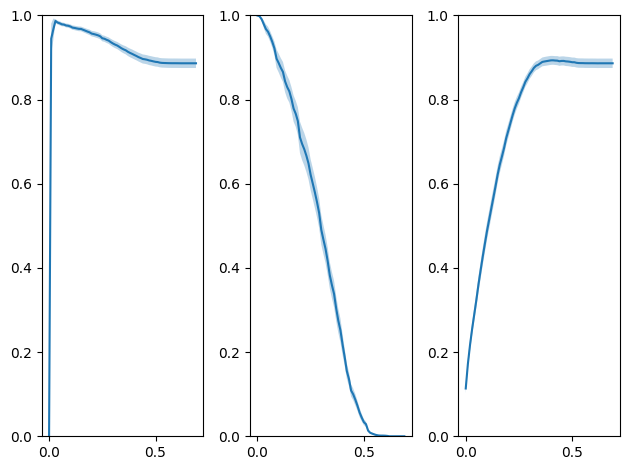

In [36]:
plt.subplot(1,3,1)
m = all_acc_cert.mean(dim=0)
plt.plot(uncertainty_thresholds, m)
si = all_acc_cert.std(dim=0)/(len(means)**0.5)
plt.fill_between(uncertainty_thresholds, m-si, m+si, alpha=0.3)
plt.ylim((0, 1))
plt.subplot(1,3,2)
m = all_uncert_inacc.mean(dim=0)
plt.plot(uncertainty_thresholds, m)
si = all_uncert_inacc.std(dim=0)/(len(means)**0.5)
plt.fill_between(uncertainty_thresholds, m-si, m+si, alpha=0.3)
plt.ylim((0, 1))
plt.subplot(1,3,3)
m = all_pavpu.mean(dim=0)
plt.plot(uncertainty_thresholds, m)
si = all_pavpu.std(dim=0)/(len(means)**0.5)
plt.fill_between(uncertainty_thresholds, m-si, m+si, alpha=0.3)
plt.ylim((0, 1))
plt.tight_layout()

#### bras unified score

In [ ]:
def filtered_dice(pred, ent_map, target, threshold):
    certain_locs = ent_map < threshold
    remaining_pred = pred[certain_locs]
    remaining_target = target[certain_locs]
    
    return fast_dice(remaining_pred, remaining_target)

def filtered_tps_score(pred, ent_map, target, threshold):
    total_tps = ((pred == 1) & (target == 1)).sum().item()
    uncertain_locs = ent_map < threshold
    
    filtered_tps = ((pred[uncertain_locs] == 1) & (target[uncertain_locs] == 1)).sum().item()
    
    return (total_tps - filtered_tps) / (total_tps + 1e-30)

def filtered_tns_score(mask, pred, ent_map, target, threshold):
    mask = mask.type(torch.bool)
    pred = pred[mask]
    ent_map = ent_map[mask]
    target = target[mask]
    
    total_tns = ((pred == 0) & (target == 0)).sum().item()
    uncertain_locs = ent_map < threshold
    
    filtered_tns = ((pred[uncertain_locs] == 0) & (target[uncertain_locs] == 0)).sum().item()
    
    return (total_tns - filtered_tns) / (total_tns + 1e-30)

#### sUEO score, UEO per threshold, max UEO?

I need to filter out bad predictions (broken images) in the visualisation of results section.

In [37]:
def sUEO(pred, ent_map, target):
    errors = (pred != target)
    
    numerator = 2 * (ent_map * errors).sum()
    denominator = (errors**2).sum() + (ent_map**2).sum()
    
    return (numerator / denominator).item()

In [38]:
def get_sUEOs(means, ys3d_test, ent_maps):
    sUEOs = []
    for i in tqdm(range(len(ent_maps)), position=0, leave=True):
        pred = means[i].argmax(dim=1).cuda()
        target = ys3d_test[i].cuda()
        ent = ent_maps[i].cuda()

        if pred.sum() == 0:
            continue

        sUEOs.append(sUEO(pred, ent, target))

    sUEOs = torch.Tensor(sUEOs)
    return sUEOs

In [39]:
sUEOs = get_sUEOs(means, ys3d_test, ent_maps)
chal_results['sUEO'] = sUEOs

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  6.43it/s]


In [40]:
def UEO_per_threshold_analysis(uncertainty_thresholds, ys3d, ind_ent_maps, means, max_ent):
    ueos = [[] for _ in range(len(uncertainty_thresholds))]
                              
    for i in tqdm(range(len(ys3d)), position=0, leave=True):
        pred = means[i].argmax(dim=1).cuda()
        target = ys3d[i].cuda()
        ent = ind_ent_maps[i].cuda()
        
        # if pred.sum() == 0:
        #     continue
        
        for j, t in enumerate((uncertainty_thresholds)):
            ueos[j].append(sUEO(pred, (ent > t).type(torch.float32), target))
    
    ueos = torch.stack([torch.Tensor(ind_ueo) for ind_ueo in ueos], dim=0)
#     ueos_mean = ueos.mean(dim=1)
#     ueos_std = ueos.std(dim=1)

#     best_index = torch.Tensor(ueos).argmax()
#     return ueos_mean, ueos_std
    return ueos

In [41]:
ueos = UEO_per_threshold_analysis(uncertainty_thresholds, ys3d_test, ent_maps, means, 0.7)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:08<00:00,  4.78it/s]


In [42]:
ueos_mean = ueos.mean(dim=1)
ueos_std = ueos.std(dim=1)

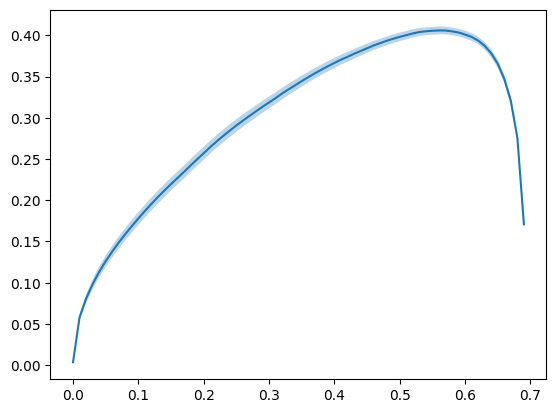

In [43]:
plt.plot(uncertainty_thresholds, ueos_mean)
sn = len(ueos_mean) ** 0.5
plt.fill_between(uncertainty_thresholds, ueos_mean - ueos_std/sn, ueos_mean + ueos_std/sn, alpha=0.3)


In [44]:
for i, tau in enumerate(uncertainty_thresholds):
    chal_results[f'UEO_{tau:.2f}'] = ueos[i]

### 2D connected components analysis

In [147]:
def conn_comp_2d_analysis(uncertainty_thresholds, ys3d, means3d, ind_ent_maps):
    conncomp_outs = []

    for y in tqdm(ys3d, position=0, leave=True, ncols=150):
        labels_out = K.contrib.connected_components(y.unsqueeze(1).type(torch.float32), num_iterations=150)
        conncomp_outs.append(labels_out)

    # this is the 1 pixel is covered by the entropy
    #c_thresholds = [0.05, 0.1, 0.2, 0.3, 0.6]
    c_thresholds = [t.item() for t in uncertainty_thresholds]
    coverages = [0.1, 0.5, 0.9]
    missing_lesion_size_ent = []
    existing_lesion_size_ent = []

    missing_lesion_size_mean = []

    num_entirely_missed_lesions = {ct:0 for ct in c_thresholds}
    entirely_missed_lesions_size = {ct:[] for ct in c_thresholds}
    proportion_missing_lesion_covered_ent = {ct:[] for ct in c_thresholds}
    num_lesions = 0
    sizes = []
    missing_area_sizes = []
    missing_area_coverage = {ct:[] for ct in c_thresholds}
    for batch in tqdm(range(len(ys3d)), position=0, leave=True, ncols=150):
        for i in range(0, ys3d[batch].shape[0], 3):
            conncomps = conncomp_outs[batch][i]
            ent = ind_ent_maps[batch][i]
            mean = means3d[batch].argmax(dim=1)[i]

            ids = conncomps.unique()[1:]
            for idx in ids:
                cc = (conncomps == idx)
                num_lesions += 1
                size = torch.sum(cc)
                sizes.append(size)

                missing_area = (mean == 0) & cc
                ma_size = missing_area.sum()
                missing_area_sizes.append(ma_size)

                # get uncertain pixels for each threshold
                for tau in c_thresholds:
                    uncert = (ent > tau).type(torch.long)

                    # coverage proportion
                    coverage = (uncert * missing_area).sum() / ma_size
                    missing_area_coverage[tau].append(coverage)


                    if torch.max(mean * cc) == 0:
                        # proportion of those lesions that are missing from mean covered by uncertainty
                        proportion_missing_lesion_covered_ent[tau].append(torch.sum(uncert * cc) / size)

                        # lesions entirely missed by both mean prediction and uncertainty map
                        # i.e not a single voxel is identified as uncertain or mean, total silent failure.
                        if torch.max(uncert * cc) == 0:
                            num_entirely_missed_lesions[tau] += 1
                            entirely_missed_lesions_size[tau].append(size)

    # replace nans and convert to tensor
    for tau in c_thresholds:
        missing_area_coverage[tau] = torch.Tensor([c.item() if not torch.isnan(c) else 0 for c in missing_area_coverage[tau]])
    
    mean_missed_area = torch.Tensor([missing_area_coverage[tau].mean().item() for tau in c_thresholds])
    mean_size_missed_lesions = torch.Tensor([torch.Tensor(entirely_missed_lesions_size[tau]).mean().item() for tau in c_thresholds])
    mean_cov_mean_missed_lesions = torch.Tensor([torch.Tensor(proportion_missing_lesion_covered_ent[tau]).mean().item() for tau in c_thresholds])
    num_missed_lesions = torch.Tensor([num_entirely_missed_lesions[tau] for tau in c_thresholds])
    prop_lesions_missed = torch.Tensor([num_entirely_missed_lesions[tau]/num_lesions for tau in c_thresholds])

    return mean_missed_area, mean_size_missed_lesions, mean_cov_mean_missed_lesions, num_missed_lesions, prop_lesions_missed, num_lesions



In [148]:
mean_missed_area, mean_size_missed_lesions, mean_cov_mean_missed_lesions, num_missed_lesions, prop_lesions_missed, num_lesions = conn_comp_2d_analysis(uncertainty_thresholds, ys3d_test, means, ent_maps)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [02:30<00:00,  3.85s/it]


#### 3D connected components analysis

In [231]:
import cc3d

def get_3d_cc_analysis(img, mean, ent, uncertainty_thresholds, ss=5, prop_size=0.5):
    mean = mean.argmax(dim=1).cuda()
    ent = ent.cuda()
    labels_in = img.cpu()
    labels_out = cc3d.connected_components(img.type(torch.int32).numpy(), connectivity=26) # 26-connected
    labels_out = torch.from_numpy(labels_out.astype(np.float32)).cuda()
    
    c_thresholds = [t.item() for t in uncertainty_thresholds]

    num_lesions = labels_out.unique().shape[0] - 1
    sizes = []
    missing_area_sizes = []
    missing_area_coverage = {ct:[] for ct in c_thresholds}
    proportion_missing_lesion_covered_ent = {ct:[] for ct in c_thresholds}
    num_entirely_missed_lesions = {ct:0 for ct in c_thresholds}
    entirely_missed_lesions_size = {ct:[] for ct in c_thresholds}

    for ccid in labels_out.unique():
        if ccid == 0:
            continue

        cc = labels_out == ccid
        size = cc.sum().item()
        sizes.append(size)

        missing_area = (mean == 0) & cc
        ma_size = missing_area.sum()
        # print(ma_size)
        missing_area_sizes.append(ma_size)

        # get uncertain pixels for each threshold
        for tau in c_thresholds:
            uncert = (ent > tau).type(torch.long)

            # coverage proportion
            coverage = (uncert * missing_area).sum() / (ma_size + 1e-30)
            missing_area_coverage[tau].append(coverage)


            ss = 5
            prop_ss = 0.5
            if torch.sum(mean * cc) <= min(size * prop_ss, ss): # (size * prop_ss):
                # proportion of those lesions that are missing from mean covered by uncertainty
                proportion_missing_lesion_covered_ent[tau].append(torch.sum(uncert * cc) / size)

                # lesions entirely missed by both mean prediction and uncertainty map
                # i.e not a single voxel is identified as uncertain or mean, total silent failure.
                if torch.sum(uncert * cc) <= min(size * prop_ss, ss): # (size * prop_ss):
                    num_entirely_missed_lesions[tau] += 1
                    entirely_missed_lesions_size[tau].append(size)

    mean_missed_area3d = torch.Tensor([torch.Tensor(missing_area_coverage[tau]).mean().item() for tau in c_thresholds])
    mean_size_missed_lesions3d = torch.Tensor([torch.Tensor(entirely_missed_lesions_size[tau]).mean().item() for tau in c_thresholds])
    mean_cov_mean_missed_lesions3d = torch.Tensor([torch.Tensor(proportion_missing_lesion_covered_ent[tau]).mean().item() for tau in c_thresholds])
    # num_missed_lesions3d = torch.Tensor([num_entirely_missed_lesions[tau] for tau in c_thresholds])
    prop_lesions_missed3d = torch.Tensor([num_entirely_missed_lesions[tau]/num_lesions for tau in c_thresholds])

    return num_lesions, sizes, mean_missed_area3d, mean_size_missed_lesions3d, mean_cov_mean_missed_lesions3d, prop_lesions_missed3d
    

num_lesions_all, sizes_all, mean_missed_area3d_all, mean_size_missed_lesions3d_all, mean_cov_mean_missed_lesions3d_all, prop_lesions_missed3d_all = [], [], [], [], [], []
for i in tqdm(range(len(means)), position=0, leave=True):
    num_lesions, sizes, mean_missed_area3d, mean_size_missed_lesions3d, mean_cov_mean_missed_lesions3d, prop_lesions_missed3d = get_3d_cc_analysis(ys3d_test[i], means[i], ent_maps[i], uncertainty_thresholds)
    num_lesions_all.append(num_lesions)
    sizes_all.append(sizes)
    mean_missed_area3d_all.append(mean_missed_area3d)
    mean_size_missed_lesions3d_all.append(mean_size_missed_lesions3d)
    mean_cov_mean_missed_lesions3d_all.append(mean_cov_mean_missed_lesions3d)
    prop_lesions_missed3d_all.append(prop_lesions_missed3d)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [02:25<00:00,  3.73s/it]


In [241]:
for i, tau in enumerate(uncertainty_thresholds):
    chal_results[f'mean_missed_area3d_all_{tau:.2f}'] = torch.stack(mean_missed_area3d_all)[:,i]
    chal_results[f'mean_cov_mean_missed_lesions3d_all_{tau:.2f}'] = torch.stack(mean_cov_mean_missed_lesions3d_all)[:,i]
    chal_results[f'mean_size_missed_lesions3d_all_{tau:.2f}'] = torch.stack(mean_size_missed_lesions3d_all)[:,i]
    chal_results[f'prop_lesions_missed3d_all_{tau:.2f}'] = torch.stack(prop_lesions_missed3d_all)[:,i]

In [235]:
pm = torch.stack(prop_lesions_missed3d_all)

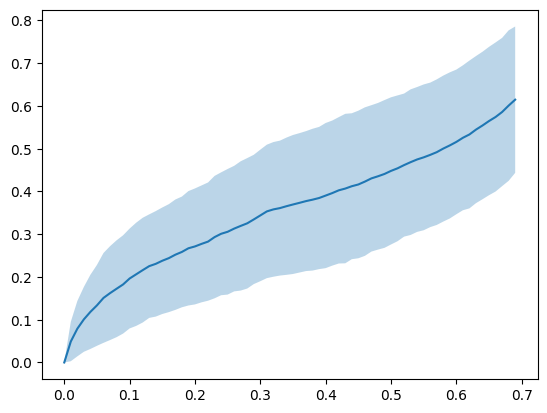

In [239]:
m = pm.mean(dim=0)
si = pm.std(dim=0)
plt.plot(uncertainty_thresholds, m)
plt.fill_between(uncertainty_thresholds, m-si, m+si, alpha=0.3)

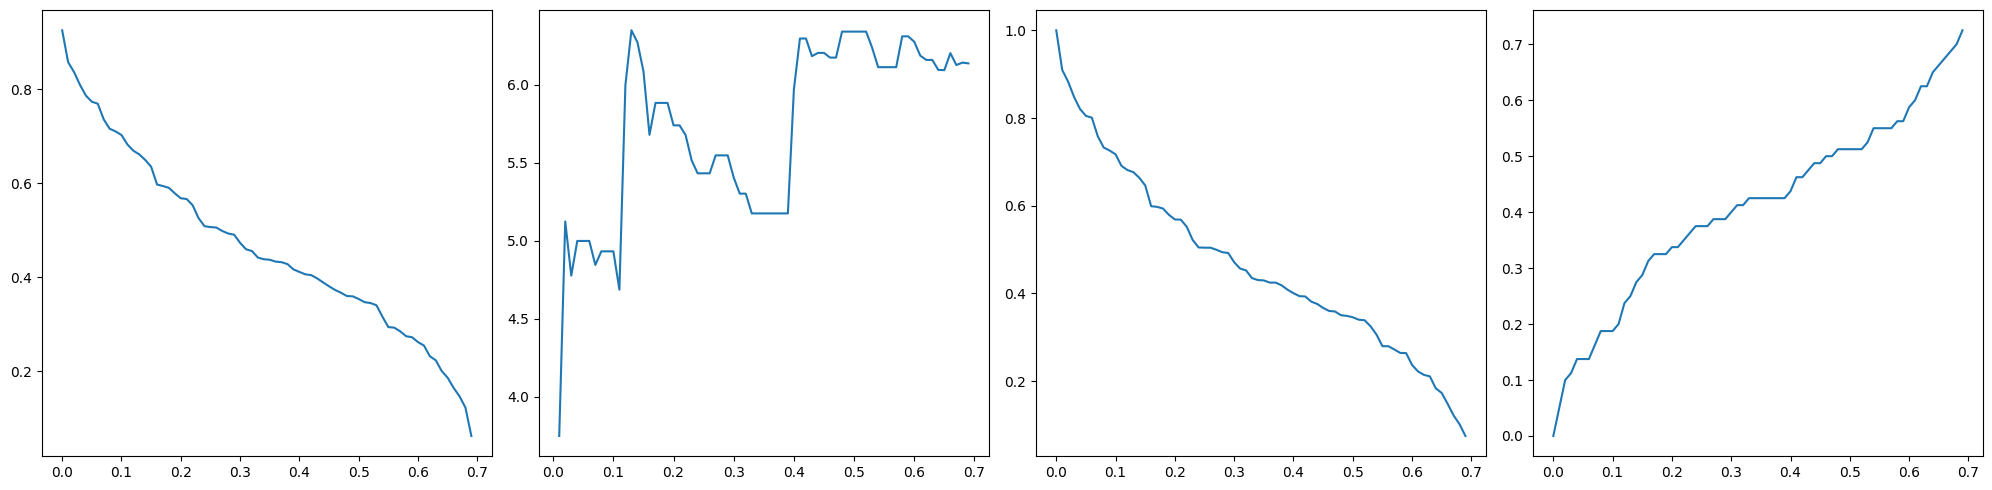

In [219]:
plt.figure(figsize=(25, 5))
plt.subplot(1,5,1)
plt.plot(uncertainty_thresholds, mean_missed_area3d)
plt.subplot(1,5,2)
plt.plot(uncertainty_thresholds, mean_size_missed_lesions3d)
plt.subplot(1,5,3)
plt.plot(uncertainty_thresholds, mean_cov_mean_missed_lesions3d)
plt.subplot(1,5,4)
plt.plot(uncertainty_thresholds, prop_lesions_missed3d)
plt.tight_layout()

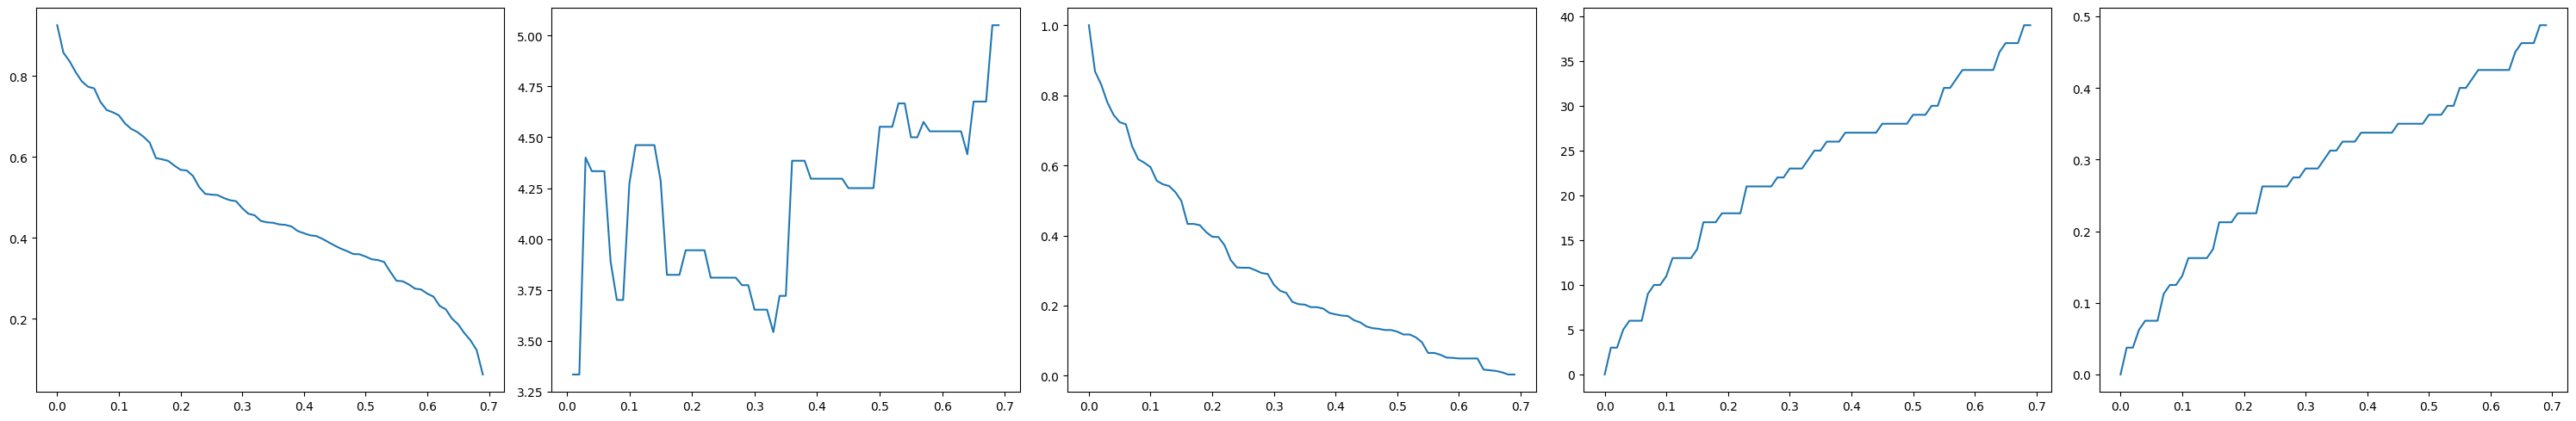

In [174]:
plt.figure(figsize=(30, 5))
plt.subplot(1,5,1)
plt.plot(uncertainty_thresholds, mean_missed_area3d)
plt.subplot(1,5,2)
plt.plot(uncertainty_thresholds, mean_size_missed_lesions3d)
plt.subplot(1,5,3)
plt.plot(uncertainty_thresholds, mean_cov_mean_missed_lesions3d)
plt.subplot(1,5,4)
plt.plot(uncertainty_thresholds, num_missed_lesions3d)
plt.subplot(1,5,5)
plt.plot(uncertainty_thresholds, prop_lesions_missed3d)
plt.tight_layout()

#### calibration

#### best sample metrics as we increase the number of samples
need to collect best dice, DGed, best rmse, mean sample rmse, best avd and best vd as we increase number of samples..... Also store something like uoe score and mean dice for ensemble, to see how well it generalizes as the sample size increases).
The way to do this is to collect the 10 or 60 samples whatever and then do the ordering each time for a new set of the samples. Then recompute the metrics each time and record the best dice for each individual, so best dice at 1, 2, 3 n samples etc. Love it, great.
How we will do 60 samples or 10 samples for the ensemble depending on the dataset needs to be worked through. Good stuff though. Love it.

### saving the results

In [52]:
# save the results
write_per_model_channel_stats(preds=None, ys3d_test=None, args=args, chal_results=chal_results)